In [38]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import math
import random
import itertools

In [39]:
data = pd.read_csv('movielens-20m/rating.csv')
movies_df = pd.read_csv("movielens-20m/movie.csv")
tags_df = pd.read_csv("movielens-20m/tag.csv")
genome_scores_raw = pd.read_csv("movielens-20m/genome_scores.csv")
data = data.iloc[:10000]
# Filter genome_scores to only have movieIds present in the data dataframe
genome_scores = genome_scores_raw[genome_scores_raw['movieId'].isin(data['movieId'].unique())]

train_data = data.copy()
test_data = pd.DataFrame()
print(len(train_data))
movie_num_user_rated_counts = train_data['movieId'].value_counts()
# Create a list of movie IDs with 50 or more ratings
popular_movies = movie_num_user_rated_counts[movie_num_user_rated_counts >= 10].index.tolist()
# Filter the DataFrame to keep only the rows with movies that meet the threshold
train_data = train_data[train_data['movieId'].isin(popular_movies)]
print(len(train_data))
for user_id in train_data['userId'].unique():
    user_ratings = train_data[train_data['userId'] == user_id]
    
    if len(user_ratings) > 1:
        test_rating = user_ratings.sample()
        test_data = pd.concat([test_data, test_rating])
        train_data.drop(test_rating.index, inplace=True)
print(len(train_data))
# Extract unique movie IDs from train data
train_movie_ids = set(train_data['movieId'].unique())

# Filter out rows in the test data that have movie IDs not present in the train data
test_data = test_data[test_data['movieId'].isin(train_movie_ids)]
print(len(train_data))

10000
3648
3557
3557


In [40]:
def make_graph(train_data, movies_df,tags_df):
    ratings_df = train_data
    # Create a new graph
    G = nx.Graph()

    # 2. Adding nodes and edges
    # Add user nodes
    for user_id in ratings_df['userId'].unique():
        G.add_node('u_'+str(user_id), bipartite=0)  # Add user node with a bipartite attribute of 0

    # Add movie nodes with title and genres as attributes
    unique_movie_ids_in_ratings = set(ratings_df['movieId'].unique())
    for _, row in movies_df.iterrows():
        movie_id = 'm_' + str(row['movieId'])
        if row['movieId'] in unique_movie_ids_in_ratings:
            G.add_node(movie_id, bipartite=1, title=row['title'], genres=row['genres'].split('|'))


    # Add edges based on ratings with rating and timestamp as attributes
    for _, row in ratings_df.iterrows():
        user_id = 'u_'+str(row['userId'])
        movie_id = 'm_' + str(row['movieId'])
        G.add_edge(user_id, movie_id, rating=row['rating'], timestamp=row['timestamp'])

    # Add tag data as an attribute to the movie nodes
    for _, row in tags_df.iterrows():
        movie_id = 'm_' + str(row['movieId'])
        if row['movieId'] in unique_movie_ids_in_ratings:
            if 'tags' not in G.nodes[movie_id]:
                G.nodes[movie_id]['tags'] = []
            G.nodes[movie_id]['tags'].append({'tag': row['tag']})


    # Ensure the graph is bipartite
    assert bipartite.is_bipartite(G)
    return G

In [41]:
def predict_rating(G, user, movie):
    neighbors = list(G.neighbors(movie))
    if not neighbors:
        return np.mean([attr['rating'] for _, _, attr in G.edges(data=True) if 'rating' in attr])

    sim_weights = []
    user_ratings = []
    for neighbor in neighbors:
        # Jaccard similarity as an example, but can be changed
        common_movies = list(nx.common_neighbors(G, user, neighbor))
        sim = len(common_movies) / (G.degree(user) + G.degree(neighbor) - len(common_movies))
        rating = G[neighbor][movie]['rating']
        
        sim_weights.append(sim)
        user_ratings.append(rating)
    
    return np.dot(user_ratings, sim_weights) / sum(sim_weights)
def recommend_top_5_movies(G, user):
    # All movies in the graph
    all_movies = [node for node in G.nodes() if node.startswith('m_')]
    
    # Movies that the user has already watched
    watched_movies = set(G.neighbors(user))
    
    # Movies to consider for recommendation
    unwatched_movies = set(all_movies) - watched_movies
    
    movie_similarities = {}

    for movie in unwatched_movies:
        # Users who have watched this movie
        users_who_watched = set(G.neighbors(movie))
        
        # Movies watched by those users
        other_movies_watched = set(neighbor for u in users_who_watched for neighbor in G.neighbors(u)) - {movie}
        
        # Common movies watched by the target user and the other users
        common_movies = watched_movies.intersection(other_movies_watched)
        
        # Jaccard similarity as an example
        sim = len(common_movies) / (len(watched_movies) + len(other_movies_watched) - len(common_movies))
        
        movie_similarities[movie] = sim

    # Sort movies by similarity and get top 5
    top_5_movies = sorted(movie_similarities, key=movie_similarities.get, reverse=True)[:5]
    top_5_movies_final = [movie[2:] for movie in top_5_movies]
    print(top_5_movies_final)
    return top_5_movies_final


In [42]:
def prepare_data(train_data, genome_scores_data):
    k_relevant_tags = 100  # Replace with the desired number
    
    # Loading the data
    ratings = train_data
    genome_scores = genome_scores_data
    
    
    # Filtering out tags that aren't that important.
    # 1. Compute the average relevance for each tag across all movies.
    avg_relevance = genome_scores.groupby('tagId')['relevance'].mean()

    # 2. Sort the tags by their average relevance and select the X tags with the lowest average relevance.
    top_tags = avg_relevance.nlargest(k_relevant_tags).index

    # 3. Filter out the data in genome_scores based on those selected tags.
    genome_scores = genome_scores[genome_scores['tagId'].isin(top_tags)]
    
    
    # Adjust relevance values in genome_scores such that the median becomes 0
    relevance_median = genome_scores['relevance'].median()
    genome_scores['relevance'] -= relevance_median

    # Scaling the values of relevance
    max_zero_centered_relevance = genome_scores['relevance'].max()
    min_zero_centered_relevance = genome_scores['relevance'].min()
    scaler_positive_values = 0.5 / max_zero_centered_relevance
    scaler_negative_values = -0.5 / min_zero_centered_relevance

    genome_scores['relevance'] = np.where(
        genome_scores['relevance'] > 0,
        genome_scores['relevance'] * scaler_positive_values,
        genome_scores['relevance'] * scaler_negative_values
    ) + 0.5

    # Make relevance and label values be mapped to closest element in bins_values
    bins_values = np.array([0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
    genome_scores['relevance'] = genome_scores['relevance'].apply(lambda x: bins_values[np.abs(bins_values - x).argmin()])

    # Converting ratings to be from 0 to 1 and mapping them to closest element in bins_values
    ratings['rating'] = (ratings['rating'] - 1) / 4
    ratings['rating'] = ratings['rating'].apply(lambda x: bins_values[np.abs(bins_values - x).argmin()])
    
    return ratings, genome_scores, bins_values


def predict_rating_for_movie(user_id, movie_id, ratings, genome_scores, bins_values):
    user_ratings = ratings[ratings['userId'] == user_id]
    movies_rated_by_user = user_ratings['movieId'].tolist()
    genome_scores_movies_rated_by_user = genome_scores[genome_scores['movieId'].isin(movies_rated_by_user)]
    
    
    # Getting the probabilities for all labels
    probability_label = {}
    for label_value in bins_values:
        probability_label[label_value] = compute_movie_output(movie_id, user_id, user_ratings, genome_scores_movies_rated_by_user, genome_scores, label_value)
    
    most_probable_label = max(probability_label, key=probability_label.get)
    return (most_probable_label * 4) + 1


def get_probability(user_ratings, genome_scores_user, tag_id, relevance, label):
    """Function to calculate the probability for a tagId based on user ratings."""
   
    # Filtered genome_scores_user with same relevance for the given tagId
    relevant_movies_rated_by_user = genome_scores_user[(genome_scores_user['tagId'] == tag_id) & (genome_scores_user['relevance'] == relevance)]
       
    if relevant_movies_rated_by_user.empty:
        return 1  # If the user hasn't rated any movies with that relevance and tagId, we'll consider a default probability of 1.
   
    # Count the number of those movies (in relevant_movies_rated_by_user) rated with a value of label
    num_rated_label = user_ratings[user_ratings['movieId'].isin(relevant_movies_rated_by_user['movieId']) & (user_ratings['rating'] == label)].shape[0]
   
    return (num_rated_label / relevant_movies_rated_by_user.shape[0]) + 1


def compute_movie_output(movie_id, user_id, user_ratings, genome_scores_user, genome_scores, label):
    """Function to compute output for a movie based on user's ratings."""
   
    # Get the tag relevance scores for the movie
    movie_relevance_scores = genome_scores[genome_scores['movieId'] == movie_id]
   
    # Calculate the probability for each tagId. It iterates through every row in movie_relevance_scores, passing as parameters the tagId (row['tagId']) and relevance (row['relevance'])
    probabilities = [get_probability(user_ratings, genome_scores_user, row['tagId'], row['relevance'], label) for _, row in movie_relevance_scores.iterrows()]
   
    # Calculate output by multiplying all the probabilities
    output = 1
    for prob in probabilities:
        output *= prob
   
    return output
def recommend_top_5_movies_bayes(ratings, user_id, genome_scores):
    label = 1
    # Filter ratings to have only the user_id ratings
    user_ratings = ratings[ratings['userId'] == user_id]
   
    # Filtering in genome_scores to only consider tags relevance of movies rated by user
    movies_rated_by_user = user_ratings['movieId'].tolist()
    genome_scores_movies_rated_by_user = genome_scores[genome_scores['movieId'].isin(movies_rated_by_user)]
   
    # Get all the movies that the user has not rated
    movies_not_rated = set(ratings['movieId'].unique()) - set(user_ratings['movieId'].unique())
   
    # Compute output for each movie not rated by the user
    outputs = {}
    for movie_id in movies_not_rated:
        outputs[movie_id] = compute_movie_output(movie_id, user_id, user_ratings, genome_scores_movies_rated_by_user, genome_scores, label)

    # Divide each element by max_value
    outputs = {key: value / max(outputs.values()) for key, value in outputs.items()}
   
    # Make it be in descending order
    outputs = dict(sorted(outputs.items(), key=lambda item: item[1], reverse=True))
   
    individual_recommending_movies = dict(itertools.islice(outputs.items(), 5))
    individual_recommending_movies = list(individual_recommending_movies.keys())
   
    return individual_recommending_movies

In [52]:

def create_pivot_table(dataknn):
    return dataknn.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(-1)

def create_knn(pivot_table):
    new_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    pivot_matrix = csr_matrix(pivot_table.values) #Required for knn
    new_knn.fit(pivot_matrix)
    return new_knn

#Takes
def predict_user_rating_rafael(userId, movieId, pivot_table, k, knn_model):
    #Get movie's nearest neighbors
    movieId_index = pivot_table.index.get_loc(movieId)
    
    #print(movieId_index)
    #print(pivot_table.iloc[movieId_index,:])
    p_distances, p_indices  = knn_model.kneighbors(pivot_table.iloc[movieId_index,:].values.reshape(1,-1), n_neighbors = k+1)
    #print(p_indices)
    p_indices = p_indices[0][1:]
    
    
    #Get users ratings for those movies
    ratings = []
    
    for index in p_indices:
        #print(pivot_table.iloc[index, userId])
        userId_index = pivot_table.columns.get_loc(userId)
        ratings.append(pivot_table.iloc[index, userId_index])
        
        
    #Average their ratings to find their predicted rating for the target movie
    average = sum(ratings)/len(ratings)
    return average


def get_recommendations_knn(userId, k, dataknn):
    pivot_table = create_pivot_table(dataknn)
    knn_model = create_knn(pivot_table)
    
    
    #We will find the user's highest rated movie, so that we can recommend them a similar movie that they are likely to like, or we make a random choice
    #from their top rated movies
    #max_movie_id, max_movie_index, max_rating = get_highest_rated_movie(userId, pivot_table)#Basic method finds a the highest rated movie for a given user (idk what happens if there are more than one say 5 star review)
    
    max_movie_id, max_movie_index = make_random_choice_from_highest_rated_movies(userId, pivot_table)#Basic method finds a the highest rated movie for a given user 
    
    #Get movie's nearest neighbors
    movieId_index = pivot_table.index.get_loc(max_movie_id)
    
    #print(movieId_index)
    #print(pivot_table.iloc[movieId_index,:])
    p_distances, p_indices  = knn_model.kneighbors(pivot_table.iloc[movieId_index,:].values.reshape(1,-1), n_neighbors = k+1)
    return [pivot_table.index[i] for i in p_indices[0][:]]


 
    
def get_highest_rated_movie(userId, pivot_table):
    user_ratings = pivot_table.loc[:, userId]  # Get the ratings for the specific user
    max_rating = user_ratings.max()  # Find the maximum rating for the user
    max_index = user_ratings.idxmax()  # Find the movieId corresponding to the maximum rating
    max_movie_id = pivot_table.index[max_index]
    print("Maximum Rating:", max_rating)
    print("MovieId with Maximum Rating:", max_index)
    return max_movie_id, max_index, max_rating
def make_random_choice_from_highest_rated_movies(userId, pivot_table):

    user_ratings_sorted = pivot_table.loc[:, userId].sort_values(ascending = False)
    user_ratings_sorted = user_ratings_sorted[user_ratings_sorted != -1] #Only consider movies they actually rated
    length = user_ratings_sorted.shape[0]
    
    if length == 0:
        raise ValueError(f"User {userId} hasn't rated any movies.")
    
    #random index from top 20% of rated movies 
    index = random.randint(0, math.floor(length*0.01))
    
    max_movie_id = user_ratings_sorted.index[index]#Get the chosen movies movieId
    max_index = pivot_table.index.get_loc(max_movie_id)#Get the index of the movieId from the original pivot table (not the sorted list)
    
    choice = user_ratings_sorted.iloc[index]
    
    return max_movie_id, max_index




In [70]:
def random_walk_legacy(G, start_node, alpha=0.85, walk_length=10):
    """Perform a random walk on graph G starting from node start_node."""
    current_node = start_node
    path = [current_node]
    
    for _ in range(walk_length):
        neighbors = list(G.neighbors(current_node))
        if random.random() < alpha and neighbors:
            current_node = random.choice(neighbors)
        else:
            current_node = start_node
        path.append(current_node)
    
    return path

def precompute_heuristics(G, movieId_list):
    heuristic_dict = {}
    for node in G.nodes():
        total_distance = 0
        for movie in movieId_list:
            movie_node = 'm_' + str(movie)
            if movie_node in G and nx.has_path(G, node, movie_node):
                total_distance += nx.shortest_path_length(G, node, movie_node)
            else:
                total_distance += 10
        heuristic_dict[node] = total_distance / len(movieId_list)
    return heuristic_dict

def combined_random_walk(G, start_node, movieId_list=None, alpha=0.85, walk_length=10, heuristic_percentage=0.5, seed=None):
    if seed:
        random.seed(seed)
    
    if movieId_list:
        heuristic_dict = precompute_heuristics(G, movieId_list)
    else:
        heuristic_dict = {node: 0 for node in G.nodes()}

    current_node = start_node
    path = [current_node]
    
    for _ in range(walk_length):
        neighbors = list(G.neighbors(current_node))
        
        if neighbors:
            weights = []
            for neighbor in neighbors:
                rating_weight = G[current_node][neighbor].get('rating', 1)
                heuristic_weight = heuristic_dict[neighbor]
                
                # Normalize the weights to [0, 1]
                max_rating = max([G[current_node][n].get('rating', 1) for n in neighbors])
                max_heuristic = max([heuristic_dict[n] for n in neighbors])
                
                normalized_rating_weight = rating_weight / max_rating if max_rating != 0 else 0
                normalized_heuristic_weight = heuristic_weight / max_heuristic if max_heuristic != 0 else 0
                
                combined_weight = (1 - heuristic_percentage) * normalized_rating_weight + heuristic_percentage * normalized_heuristic_weight
                weights.append(combined_weight)

            
            if random.random() < alpha:
                current_node = weighted_choice(neighbors, weights)
            else:
                current_node = start_node
        else:
            current_node = start_node
            
        path.append(current_node)
    
    return path

def weighted_choice(neighbors, weights):
    total_sum = sum(weights)
    normalized_list = [x / total_sum for x in weights]
    return random.choices(neighbors, weights)[0]

def random_walk(G, start_node, alpha=0.85, walk_length=10, seed=None):
    """Perform a random walk on graph G starting from node start_node."""
    if seed:
        random.seed(seed)
    current_node = start_node
    path = [current_node]
    
    for _ in range(walk_length):
        if seed:
            seed=seed+1
        neighbors = list(G.neighbors(current_node))
        
        if neighbors:
            # Get weights (ratings) of the edges to the neighbors
            weights = [G[current_node][neighbor].get('rating', 1) for neighbor in neighbors]
            
            if random.random() < alpha:
                current_node = weighted_choice(neighbors, weights)
            else:
                current_node = start_node
        else:
            current_node = start_node
            
        path.append(current_node)
    
    return path
def personalized_pagerank_recommendations(G, user,percentage=0.5, movieId_check=None ,alpha=0.85, num_walks=100, walk_length=10, seed=None ,ratings= None, genome_scores=None):
    """Generate recommendations and explanations using Personalized PageRank via random walks."""
    # Perform random walks and keep track of visit counts
    visit_counts = {node: 0 for node in G.nodes()}
    all_paths = []
    user = 'u_'+str(user)
    if movieId_check:
        match movieId_check:
            case 3:
                movieId_list=get_recommendations_knn(int(user[2:]), 50, train_data.drop('timestamp', axis=1))[:5]
                print(movieId_list)
            case 1: 
                movieId_list=recommend_top_5_movies(G,user)
                print(movieId_list)
            case 2:
                movieId_list=recommend_top_5_movies_bayes( ratings, int(user[2:]), genome_scores)
                print(movieId_list)
            case _:
                raise RuntimeError("Movie ID check failed")
    for _ in range(num_walks):
        if seed:
            seed=seed+10*walk_length
        if movieId_check:
            path = combined_random_walk(G, user, movieId_list=movieId_list,alpha=alpha, walk_length=walk_length,heuristic_percentage=percentage, seed=seed)
        else:
            path = random_walk(G, user, alpha=alpha, walk_length=walk_length, seed=seed)
        all_paths.append(path)
        for node in path:
            visit_counts[node] += 1
    
    # Normalize visit counts to get a probability distribution
    total_visits = sum(visit_counts.values())
    ppr = {node: count/total_visits for node, count in visit_counts.items()}
    
    # Filter for movies and sort by PPR score
    movies = [node for node in ppr.keys() if G.nodes[node]['bipartite'] == 1 and node not in G.neighbors(str(user))]
    sorted_movies = sorted(movies, key=lambda x: ppr[x], reverse=True)
    
    # Generate explanations for the top 10 movies
    explanations = {}
    significant_neighbors = {}
    contributing_paths_all = {}
    for movie in sorted_movies:
        # Find paths that contributed to the movie's score
        contributing_paths = [path for path in all_paths if movie in path]

        contributing_paths_all[movie] = contributing_paths
    return sorted_movies, contributing_paths_all,visit_counts

In [68]:
def analyze_contributing_paths(G, movie, contributing_paths):
    genre_counts = {}
    neighbor_counts = {}
    
    for path in contributing_paths:
    

        neighbor = path[1]
        if neighbor.startswith('m_'):
            # Count the movie neighbor
            neighbor_counts[neighbor] = neighbor_counts.get(neighbor, 0) + 1
            
            # Count its genres
            genres = G.nodes[neighbor].get('genres', [])
            for genre in genres:
                genre_counts[genre] = genre_counts.get(genre, 0) + 1


    most_significant_genre = max(genre_counts, key=genre_counts.get, default=None)
    most_significant_neighbor = max(neighbor_counts, key=neighbor_counts.get, default=None)

    return most_significant_genre, most_significant_neighbor


In [46]:
def id_to_name(movie_id, movies_df):
    movie_row = movies_df[movies_df['movieId'] == movie_id]
    if not movie_row.empty:
        return movie_row['title'].iloc[0]
    else:
        return None

In [47]:

G = make_graph(train_data,movies_df,tags_df)
largest_cc = max(nx.connected_components(G), key=len)
print(G)
NG=G.subgraph(largest_cc)
print(NG)
print(list(G.edges(data=True))[:10])  
print(list(NG.edges(data=True))[:10]) 
print(nx.is_connected(G)) 


Graph with 308 nodes and 3557 edges
Graph with 308 nodes and 3557 edges
[('u_1', 'm_32', {'rating': 3.5, 'timestamp': '2005-04-02 23:33:39'}), ('u_1', 'm_47', {'rating': 3.5, 'timestamp': '2005-04-02 23:32:07'}), ('u_1', 'm_50', {'rating': 3.5, 'timestamp': '2005-04-02 23:29:40'}), ('u_1', 'm_151', {'rating': 4.0, 'timestamp': '2004-09-10 03:08:54'}), ('u_1', 'm_223', {'rating': 4.0, 'timestamp': '2005-04-02 23:46:13'}), ('u_1', 'm_253', {'rating': 4.0, 'timestamp': '2005-04-02 23:35:40'}), ('u_1', 'm_260', {'rating': 4.0, 'timestamp': '2005-04-02 23:33:46'}), ('u_1', 'm_293', {'rating': 4.0, 'timestamp': '2005-04-02 23:31:43'}), ('u_1', 'm_296', {'rating': 4.0, 'timestamp': '2005-04-02 23:32:47'}), ('u_1', 'm_318', {'rating': 4.0, 'timestamp': '2005-04-02 23:33:18'})]
[('u_1', 'm_32', {'rating': 3.5, 'timestamp': '2005-04-02 23:33:39'}), ('u_1', 'm_47', {'rating': 3.5, 'timestamp': '2005-04-02 23:32:07'}), ('u_1', 'm_50', {'rating': 3.5, 'timestamp': '2005-04-02 23:29:40'}), ('u_1', '

In [67]:
user = train_data['userId'].sample().iloc[0]
print(nx.is_connected(G))

movies, paths, visitcounts = personalized_pagerank_recommendations(G,user, movieId_check=3)
for movie in movies[:10]:
    print(analyze_contributing_paths(G,movie,paths[movie]))
ratings, genome_scores, bins_values = prepare_data(train_data, genome_scores)
movies, paths, visitcounts = personalized_pagerank_recommendations(G,user, movieId_check=2,ratings=ratings,genome_scores=genome_scores)
for movie in movies[:10]:
    print(analyze_contributing_paths(G,movie,paths[movie]))


True
[1, 95, 733, 1073, 786, 7, 1552, 1573, 1408, 173, 551, 1917, 553, 587, 317, 788, 2012, 2916, 1242, 648, 1784, 1676, 3, 1215, 2407, 1625, 653, 832, 104, 1517, 160, 32, 208, 1527, 2355, 474, 780, 1682, 2174, 342, 539, 223, 34, 288, 62, 2396, 410, 2791, 508, 3147, 953]
['u_14', 'm_1101', 'u_7', 'm_2716', 'u_14', 'm_457', 'u_15', 'u_14', 'm_1198', 'u_53', 'm_527']
['u_14', 'm_356', 'u_4', 'm_454', 'u_54', 'm_527', 'u_41', 'm_912', 'u_63', 'm_912', 'u_7']
['u_14', 'm_1073', 'u_24', 'm_25', 'u_56', 'm_527', 'u_53', 'm_608', 'u_14', 'u_14', 'm_150']
['u_14', 'm_1', 'u_19', 'm_648', 'u_12', 'm_527', 'u_14', 'm_587', 'u_16', 'm_1197', 'u_14']
['u_14', 'u_14', 'm_1101', 'u_7', 'm_316', 'u_32', 'm_47', 'u_64', 'm_527', 'u_53', 'm_1207']
['u_14', 'm_1265', 'u_69', 'm_260', 'u_14', 'm_1262', 'u_63', 'm_527', 'u_70', 'u_14', 'm_924']
Genre counts: {'Action': 1, 'Romance': 3, 'Comedy': 4, 'Drama': 1, 'War': 1, 'Children': 2, 'Fantasy': 3, 'Musical': 1, 'Adventure': 1, 'Animation': 1}
Neighbor co

In [98]:
def compute_CF(G, user, alpha=0.85, num_walks=10000, walk_length=10, seed=None, evaluation_type='neighbor'):
    movies, paths, visit_counts = personalized_pagerank_recommendations(G, user, alpha=alpha, num_walks=num_walks, walk_length=walk_length, seed=seed)
    
    # Get the most significant genre and neighbor for the top recommended movie
    most_significant_genre, most_significant_neighbor = analyze_contributing_paths(G, movies[0], paths[movies[0]])
    
    # Modify the graph based on the evaluation type
    if evaluation_type == 'neighbor':
        if G.has_edge('u_'+str(user), most_significant_neighbor):
            G.remove_edge('u_'+str(user), most_significant_neighbor)
    elif evaluation_type == 'genre':
        for node in G.nodes():
            if 'genres' in G.nodes[node] and most_significant_genre in G.nodes[node]['genres']:
                if G.has_edge('u_'+str(user), node):
                    G.remove_edge('u_'+str(user), node)
    elif evaluation_type == 'random':
        neighbors = list(G.neighbors('u_'+str(user)))
        if neighbors:
            random_neighbor = random.choice(neighbors)
            G.remove_edge('u_'+str(user), random_neighbor)
    else:
        raise ValueError("Invalid evaluation_type. Choose 'neighbor', 'genre', or 'random'.")
    
    movies_modified, _, visit_counts_modified = personalized_pagerank_recommendations(G, user, alpha=alpha, num_walks=num_walks, walk_length=walk_length, seed=seed)
    first_movie = movies[0]

    if first_movie in movies_modified:
        error = abs(visit_counts[first_movie] - visit_counts_modified[first_movie])
    else:
        error = visit_counts[first_movie]

    return error



In [ ]:
import math
def modified_dcg(recommended, user_ratings):
    """Compute the modified DCG based on the position in the recommendations and the movie rating."""
    score = 0.0
    for i, movie in enumerate(recommended):
        if int(movie[2:]) in user_ratings:
            score += user_ratings[int(movie[2:])] / math.log2(i + 2)  # +2 because log2(1) is 0 and we start indexing from 0
    return score

def evaluate_pagerank_recommendations_dcg(G, train_data, test_data , num_walks = 100, walk_length=10, percentage=0.5,heuristic=None):
    """Evaluate personalized PageRank recommendations using the modified DCG."""
    scores = []
    
    for user_id in train_data['userId'].unique():
        # Get the ratings for the user from the test set
        user_ratings_df = test_data[test_data['userId'] == user_id]
        user_ratings = dict(zip(user_ratings_df['movieId'], user_ratings_df['rating']))
        
        # Get the top-k recommendations for the user
        recommended, _,  _ = personalized_pagerank_recommendations(G, user_id,percentage=percentage,movieId_check=heuristic,num_walks=num_walks,walk_length=walk_length)
        
        # Compute the modified DCG for the user
        scores.append(modified_dcg(recommended, user_ratings))
    
    # Compute the average score over all users
    avg_score = sum(scores) / len(scores)
    
    return avg_score



In [ ]:
import random

def random_baseline_recommendations(user_id, train_data):
    """Recommend movies in a random order."""
    all_movies = train_data['movieId'].unique().tolist()
    
    # Exclude movies the user has already rated
    user_rated_movies = train_data[train_data['userId'] == user_id]['movieId'].tolist()
    recommendable_movies = ['m_'+str(movie) for movie in all_movies if movie not in user_rated_movies]
    
    # Shuffle the list to get random recommendations
    random.shuffle(recommendable_movies)
    
    return recommendable_movies

def evaluate_random_baseline_dcg(train_data, test_data):
    """Evaluate the random baseline recommendations using the modified DCG."""
    scores = []
    
    for user_id in train_data['userId'].unique():
        # Get the ratings for the user from the test set
        user_ratings_df = test_data[test_data['userId'] == user_id]
        user_ratings = dict(zip(user_ratings_df['movieId'], user_ratings_df['rating']))
        
        # Get the random baseline recommendations for the user
        recommended = random_baseline_recommendations(user_id, train_data)
        
        # Compute the modified DCG for the user
        scores.append(modified_dcg(recommended, user_ratings))
        if len(scores) > 10:
            break
    
    # Compute the average score over all users
    avg_score = sum(scores) / len(scores)
    
    return avg_score

# Evaluate the random baseline recommendations
random_baseline_avg_score = evaluate_random_baseline_dcg(train_data, test_data)
print(f"Random Baseline Average Modified DCG: {random_baseline_avg_score:.4f}")


Random Baseline Average Modified DCG: 0.5510


In [ ]:
import matplotlib.pyplot as plt

# List of percentage values to evaluate
percentage_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]  # [0, 0.05, 0.1, ..., 1]

# Lists to store the average mDCG values for each heuristic and each percentage value
random_scores = []
heuristic_0_scores = []
heuristic_1_scores = []
heuristic_2_scores = []

for percentage in percentage_values:
    # Evaluate with random heuristic
    random_avg_score = evaluate_random_baseline_dcg(train_data, test_data)
    random_scores.append(random_avg_score)
    
    # Evaluate with heuristic=0
    heuristic_0_avg_score = evaluate_pagerank_recommendations_dcg(G, train_data, test_data, percentage=percentage, heuristic=3)
    heuristic_0_scores.append(heuristic_0_avg_score)
    
    # Evaluate with heuristic=1
    heuristic_1_avg_score = evaluate_pagerank_recommendations_dcg(G, train_data, test_data, percentage=percentage, heuristic=1)
    heuristic_1_scores.append(heuristic_1_avg_score)

    heuristic_2_avg_score = evaluate_pagerank_recommendations_dcg(G, train_data, test_data, percentage=percentage, heuristic=2)
    heuristic_2_scores.append(heuristic_1_avg_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(percentage_values, random_scores, marker='o', label='Random', color='blue')
plt.plot(percentage_values, heuristic_0_scores, marker='o', label='KNN', color='red')
plt.plot(percentage_values, heuristic_1_scores, marker='o', label='Jaccard', color='green')
plt.plot(percentage_values, heuristic_2_scores, marker='o', label='Bayes', color='yellow')
plt.xlabel('Percentage')
plt.ylabel('Average Modified DCG')
plt.title('Comparison of Different Heuristics')
plt.legend()
plt.grid(True)
plt.show()




3557
userId    1    2    3    4    5    6    7    8    9    10  ...   82   83   84  \
movieId                                                    ...                  
1       -1.0 -1.0  0.0 -1.0 -1.0  0.0 -1.0  0.0 -1.0  0.0  ...  0.0 -1.0  0.0   
3       -1.0  0.0 -1.0 -1.0 -1.0  0.0  0.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
6       -1.0 -1.0 -1.0  0.0 -1.0 -1.0 -1.0  0.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
7       -1.0 -1.0 -1.0 -1.0 -1.0  0.0  0.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
10      -1.0 -1.0 -1.0  0.0 -1.0 -1.0 -1.0  0.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4993     0.0 -1.0 -1.0 -1.0 -1.0 -1.0  0.0 -1.0 -1.0 -1.0  ...  0.0  0.0 -1.0   
5952     0.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  0.0  0.0 -1.0   
6539     0.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
7153     0.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  0.0  0.0 -1.0   
7361    -1.0 -1.0 -1.0 

TypeError: 'NoneType' object is not subscriptable

Action m_1136
Action m_1136
Sci-Fi m_266
Sci-Fi m_266
Sci-Fi m_1230
Sci-Fi m_1230
Action m_454
Action m_454
Comedy m_11
Comedy m_11
Comedy m_17
Comedy m_17
Action m_589
Action m_589
Drama m_500
Drama m_500
Drama m_2959
Drama m_2959
Drama m_1230
Drama m_1230
Action m_173
Action m_173
Adventure m_344
Adventure m_344
Drama m_161
Drama m_161
Comedy m_150
Comedy m_150
Drama m_364
Drama m_364
Comedy m_1500
Comedy m_1500
Action m_1270
Action m_1270
Drama m_912
Drama m_912
Comedy m_62
Comedy m_62
Drama m_2023
Drama m_2023
Drama m_1961
Drama m_1961
Thriller m_16
Thriller m_16
Drama m_1580
Drama m_1580
Drama m_1704
Drama m_1704
Comedy m_590
Comedy m_590
Drama m_318
Drama m_318
Comedy m_1265
Comedy m_1265
Comedy m_296
Comedy m_296
Drama m_292
Drama m_292
Drama m_2324
Drama m_2324
Adventure m_6539
Adventure m_6539
Drama m_39
Drama m_39
Action m_1230
Action m_1230
Comedy m_736
Comedy m_736
Drama m_50
Drama m_50
Drama m_2023
Drama m_2023
Drama m_1617
Drama m_1617
Thriller m_47
Thriller m_47
Adventur

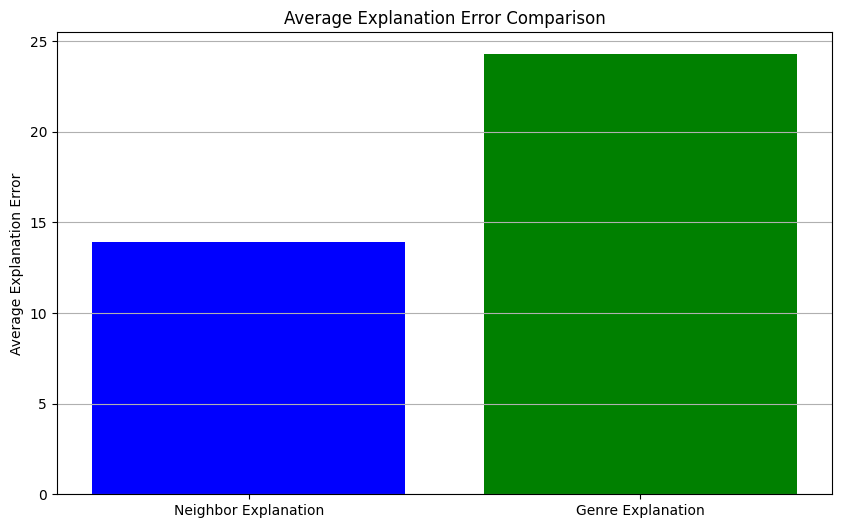

In [84]:
import numpy as np
import matplotlib.pyplot as plt

user_errors_neighbor = []
user_errors_genre = []

for user in test_data['userId']:
    G_test = G.copy()
    
    # Compute error for neighbor explanation
    user_error_neighbor = compute_CF(G_test, user, num_walks=10000, seed=42, evaluation_type='neighbor')
    user_errors_neighbor.append(user_error_neighbor)
    
    # Compute error for genre explanation
    G_test = G.copy()  # Reset the graph copy
    user_error_genre = compute_CF(G_test, user, num_walks=10000, seed=42, evaluation_type='genre')
    user_errors_genre.append(user_error_genre)

# Compute the average errors
avg_error_neighbor = np.mean(user_errors_neighbor)
avg_error_genre = np.mean(user_errors_genre)

# Plotting
labels = ['Neighbor Explanation', 'Genre Explanation']
errors = [avg_error_neighbor, avg_error_genre]

plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['blue', 'green'])
plt.title('Average Explanation Error Comparison')
plt.ylabel('Average Explanation Error')
plt.grid(axis='y')
plt.savefig("comparison.png")
plt.show()


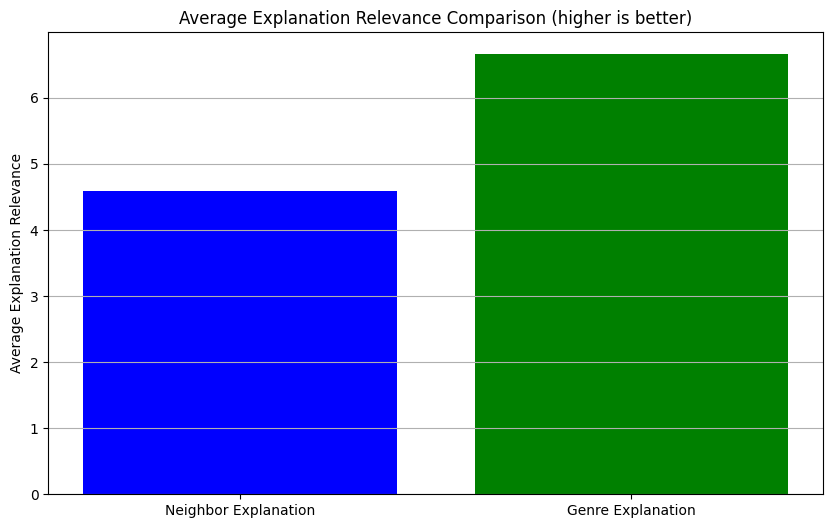

In [81]:
plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['blue', 'green'])
plt.title('Average Explanation Relevance Comparison (higher is better)')
plt.ylabel('Average Explanation Relevance')
plt.grid(axis='y')
plt.savefig("comparison.png")
plt.show()

KeyError: 'random'

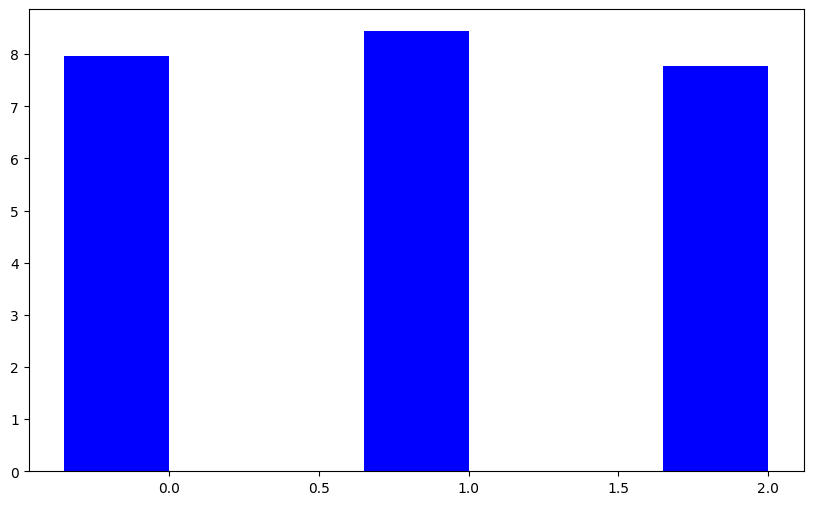

In [99]:
import pandas as pd
import random

def combine_preference_of_indiv_to_make_group_recommendation(G, users):
    # Get ranked movies for each user
    all_users_movie_ranking = {user: personalized_pagerank_recommendations(G, user)[0] for user in users}
    
    # Find common movies among all users
    common_movies = set(all_users_movie_ranking[users[0]])
    for user_movies in all_users_movie_ranking.values():
        common_movies.intersection_update(user_movies)
    
    # Create a dataframe for global ranking
    global_ranking_df = pd.DataFrame(index=list(common_movies), columns=users)
    
    # Fill the dataframe with rankings
    for user, movies in all_users_movie_ranking.items():
        for rank, movie in enumerate(movies, 1):
            if movie in common_movies:
                global_ranking_df.at[movie, user] = rank

    # Calculate the average ranking position
    global_ranking_df['Ranking Position'] = global_ranking_df.mean(axis=1)
    global_ranking_df = global_ranking_df.sort_values(by='Ranking Position')
    top_movie_id_or_name = global_ranking_df.index[0]
    return top_movie_id_or_name

# Generate random user groups
def generate_random_user_groups(all_users, group_size=5, num_groups=10):
    return [random.sample(all_users, group_size) for _ in range(num_groups)]

all_users = list(test_data['userId'].unique())
random_groups = generate_random_user_groups(all_users, group_size=5, num_groups=10)
def group_explanations(G, groups):
    explanations = {}
    errors = {'neighbor': [], 'genre': []}
    
    for group in groups:
        # Get the top recommended movie for the group
        top_movie = combine_preference_of_indiv_to_make_group_recommendation(G, group)
        
        # Get all paths contributing to this movie's recommendation for the group
        all_paths_for_group = []
        for user in group:
            _, paths, _ = personalized_pagerank_recommendations(G, user)
            if top_movie in paths:
                all_paths_for_group.extend(paths[top_movie])
        
        # Get the most significant genre and neighbor for the top movie
        most_significant_genre, most_significant_neighbor = analyze_contributing_paths(G, top_movie, all_paths_for_group)
        
        # Store the explanations
        explanations[tuple(group)] = {
            'top_movie': top_movie,
            'most_significant_genre': most_significant_genre,
            'most_significant_neighbor': most_significant_neighbor
        }
        
        # Compute the errors for both explanations for the group using the existing CF function
        for eval_type, significant_item in [('neighbor', most_significant_neighbor), ('genre', most_significant_genre)]:
            group_errors = []
            for user in group:
                G_copy = G.copy()
                error = compute_CF(G_copy, user, evaluation_type=eval_type, num_walks=1000)
                group_errors.append(error)
            errors[eval_type].append(np.mean(group_errors))
    
    return explanations, errors

all_users = list(test_data['userId'].unique())
random_groups = generate_random_user_groups(all_users, group_size=5, num_groups=10)

# Compute errors for individual users
individual_errors = {'neighbor': [], 'genre': [], 'random': []}
for user in test_data['userId']:
    for eval_type in ['neighbor', 'genre', 'random']:
        G_copy = G.copy()
        error = compute_CF(G_copy, user, evaluation_type=eval_type, num_walks=1000)
        individual_errors[eval_type].append(error)

# Compute average errors for individual users
avg_individual_errors = {key: np.mean(val) for key, val in individual_errors.items()}

# Compute errors for groups using the group_explanations function
explanations, group_errors = group_explanations(G, random_groups)

# Compute average errors for groups
avg_group_errors = {key: np.mean(val) for key, val in group_errors.items()}

# Plotting
labels = ['Neighbor Explanation', 'Genre Explanation', 'Random Explanation']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [avg_individual_errors['neighbor'], avg_individual_errors['genre'], avg_individual_errors['random']], width, label='Individual', color='blue')
rects2 = ax.bar(x + width/2, [avg_group_errors['neighbor'], avg_group_errors['genre'], avg_group_errors['random']], width, label='Group', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Explanation Relevance')
ax.set_title('Average Explanation Relevance Comparison (higher is better)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()



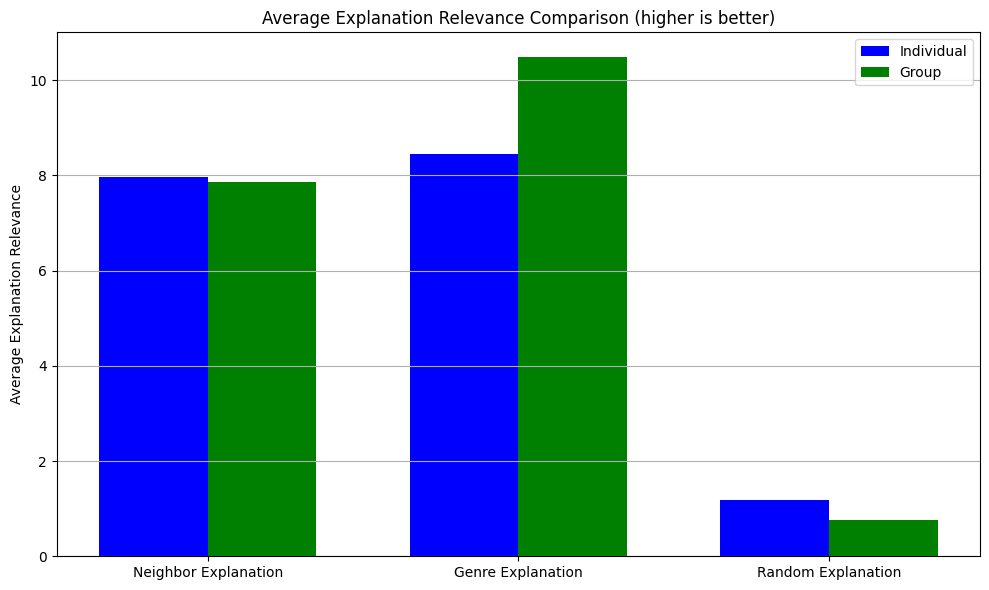

In [107]:
labels = ['Neighbor Explanation', 'Genre Explanation', 'Random Explanation']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [avg_individual_errors['neighbor'], avg_individual_errors['genre'], 1.18], width, label='Individual', color='blue')
rects2 = ax.bar(x + width/2, [avg_group_errors['neighbor'], avg_group_errors['genre'],0.76], width, label='Group', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Explanation Relevance')
ax.set_title('Average Explanation Relevance Comparison (higher is better)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()


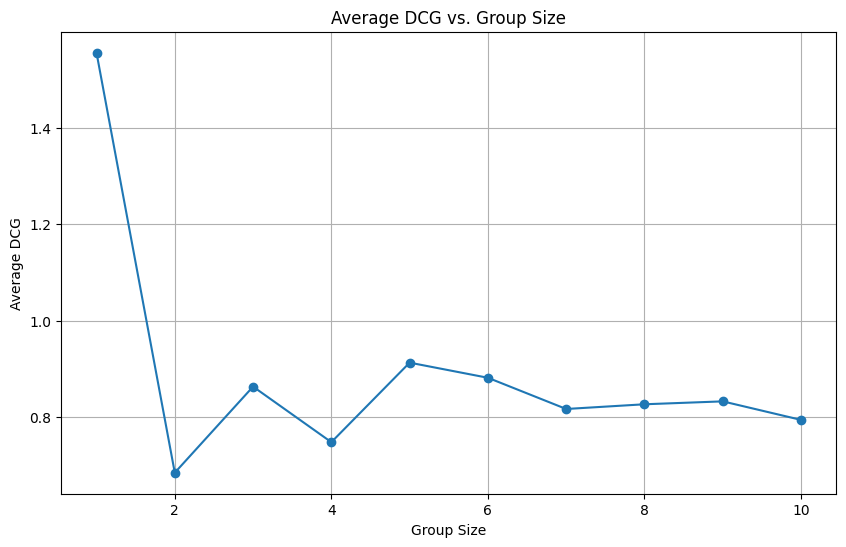

In [92]:

def combine_preference_of_indiv_to_make_group_recommendation(G, users, k=10):
    """Return top-k recommendations for a group."""
    all_users_movie_ranking = {user: personalized_pagerank_recommendations(G, user, num_walks=1000, seed=42)[0] for user in users}
    
    # Aggregate rankings for all movies
    aggregated_rankings = {}
    for user, movies in all_users_movie_ranking.items():
        for rank, movie in enumerate(movies, 1):
            if movie not in aggregated_rankings:
                aggregated_rankings[movie] = 0
            aggregated_rankings[movie] += rank
    
    # Sort movies by their aggregated rank
    sorted_movies = sorted(aggregated_rankings, key=aggregated_rankings.get)
    
    return sorted_movies
def evaluate_group_recommendations_dcg(G, train_data, test_data, group, k=10):
    """Compute the average DCG for a group of users."""
    scores = []
    
    # Get the top-k recommendations for the group
    recommended = combine_preference_of_indiv_to_make_group_recommendation(G, group)
    
    for user_id in group:
        # Get the ratings for the user from the test set
        user_ratings_df = test_data[test_data['userId'] == user_id]
        user_ratings = dict(zip(user_ratings_df['movieId'], user_ratings_df['rating']))
        
        # Compute the modified DCG for the user
        scores.append(modified_dcg(recommended, user_ratings))
    
    # Compute the average score over all users in the group
    avg_score = sum(scores) / len(scores)
    
    return avg_score

# Evaluate the group algorithm for different group sizes
group_sizes = list(range(1, 11))  # Group sizes from 1 to 10
avg_scores = []

all_users = list(test_data['userId'].unique())

for size in group_sizes:
    random_groups = generate_random_user_groups(all_users, group_size=size, num_groups=10)
    group_scores = [evaluate_group_recommendations_dcg(G, train_data, test_data, group) for group in random_groups]
    avg_scores.append(sum(group_scores) / len(group_scores))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(group_sizes, avg_scores, marker='o', linestyle='-')
plt.title('Average DCG vs. Group Size')
plt.xlabel('Group Size')
plt.ylabel('Average DCG')
plt.grid(True)
plt.show()


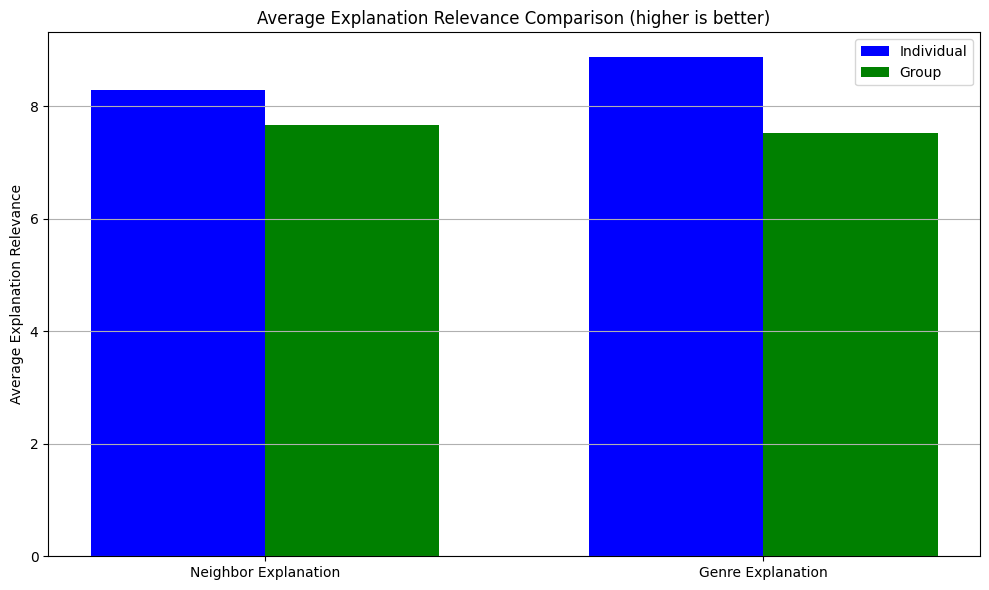